### Initialize and read compressed dataset

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

### Read combined raw impressions

In [18]:
# load data from a compressed archive
df = pd.read_pickle('../rawimps/combined.pickle')

### Cardinalities of imps, pubs, and users

In [4]:
nImps = len(df)
nPubs = len(df.pub_domain.unique())
nUsers = len(df.user_id.unique())
print('nImps={}\nnPubs={}\nnUsers={}'.format(nImps, nPubs, nUsers))

nImps=9098807
nPubs=41576
nUsers=3696476


In [81]:
df2 = df[df.click == True]
nImps2 = len(df2)
nPubs2 = len(df2.pub_domain.unique())
nUsers2 = len(df2.user_id.unique())
print('nImps2={}\nnPubs2={}\nnUsers2={}'.format(nImps2, nPubs2, nUsers2))

nImps2=10845
nPubs2=1888
nUsers2=8078


### Clicks

In [70]:
nClicks = df.click.value_counts()[True]
print('nClicks={} ({}%)'.format(nClicks, round(float(nClicks) * 100 / nImps, 2)))

nClicks=10845 (0.12%)


### Views

In [75]:
nViews = df.viewed.value_counts()[True]
print('nViews={} ({}%)'.format(nViews, round(float(nViews) * 100 / nImps, 2)))

nViews=3649597 (40.11%)


### Size of user / item matrix

In [83]:
uimsz = (nPubs * nUsers) # all visits
uimsz2 = (nPubs2 * nUsers2) # clicks
print('uim, all imps: {}, clicks only: {}'. format(uimsz, uimsz2))

uim, all imps: 67564392, clicks only: 15251264


In [78]:
f = df.groupby('pub_domain').size()

In [89]:
np.log10(10)

1.0

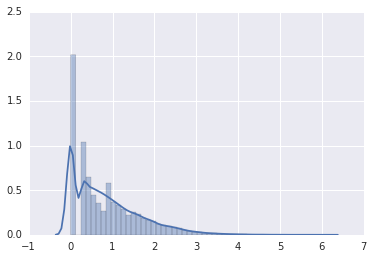

In [90]:
sns.distplot(np.log10(f));

In [97]:
g.describe()

count    3696475.000000
mean           2.461481
std           13.130454
min            1.000000
25%            1.000000
50%            1.000000
75%            1.000000
max         4375.000000
dtype: float64

In [48]:
df.head()

,timestamp,click,viewed,v_secs,user_id,operating_system,pub_domain
0,2015-09-28 09:01:35,False,False,0,9b644f47729749cc80ac9a67df399cb0,Windows,D10037853.com
1,2015-09-21 00:25:42,False,True,3,f5b295de8cf1448c8fde3b4cb1650873,Windows,D10031681.com
2,2015-09-08 00:08:49,False,False,0,06c757b7637647fb96b2d911303d5ed5,Windows,D10013014.com
3,2015-09-15 09:37:24,False,False,0,0dfabf89-5da8-459d-a4f7-3dfea37497f5,Windows,D10013014.com
4,2015-09-25 06:23:47,False,False,0,4171bedc8a99412a980c8521eee86c83,Windows,D10013014.com


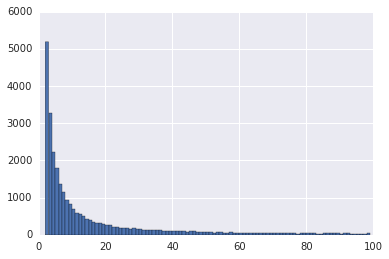

In [44]:
_ = plt.hist(df.pub_domain.value_counts(), bins=range(2,100,1))

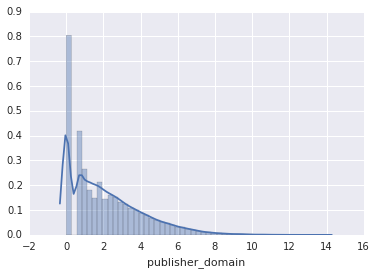

In [15]:
sns.distplot(np(f));

#### substitute integer indices for user and pub symbolic keys

In [43]:
df5.set_index(df5.pub_domain, inplace=True)

In [44]:
users = df5.user_id.unique()
pubs = df5.pub_domain.unique()

In [45]:
user_idx, pub_idx = {}, {}
for i in range(len(users)):
    user_idx[users[i]] = i
for i in range(len(pubs)):
    pub_idx[pubs[i]] = i

In [46]:
pidx = {b: a for a, b in pub_idx.items()}    # for reverse lookup pub_domain = pidx[integer_key]

### SVD

#### create sparse matrix

In [167]:
def makeUIM(df):
    dframe = df.sort_values(by='user_id', axis=0)
    nUsers = len(user_idx)
    nPubs = len(dframe.pub_domain.unique())
    V = sp.lil_matrix((nUsers, nPubs))
    def matput(imp):
        try:
            if imp.viewed:
                V[user_idx[imp.user_id], pub_idx[imp.pub_domain]] = 1
        except:
            pass
    _ = dframe[dframe.click == True].apply(matput, axis=1)
    return V

In [168]:
df5 = df5.sort_values(by='user_id', axis=0)
V = makeUIM(df5)
V

<10688x11474 sparse matrix of type '<type 'numpy.float64'>'
	with 3002 stored elements in LInked List format>

In [169]:
T = makeUIM(df6)
T

<10688x4069 sparse matrix of type '<type 'numpy.float64'>'
	with 332 stored elements in LInked List format>

### compute SVD

In [ ]:
u, s, vt = svds(V, k = 400)

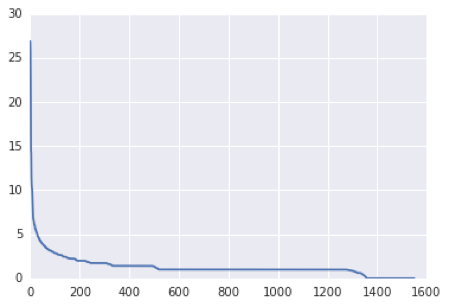

In [ ]:
plt.plot(s[::-1])

### KNN

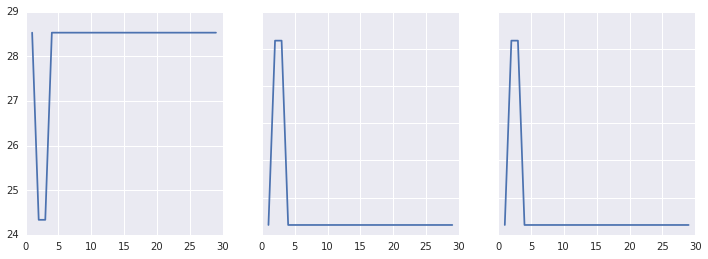

In [196]:
from sklearn.neighbors import NearestNeighbors
ts0 = df6.pub_domain.value_counts()
tsums = pd.DataFrame.from_dict({
        'pub_domain': ts0.index,
        'nImps': ts0,
        'clicks': df6.groupby('pub_domain')['click'].aggregate(sum)
    })
tsums.reset_index(inplace=True)
tsums['CTR'] = tsums.clicks / np.float64(tsums.nImps)

tt = TT.todense()
tt = np.asarray(tt)
plt.rcParams["figure.figsize"] = [12.0, 4.0]

kMin = 1
kMax = 30
weightFunctions = {
    'f1': lambda x: [1 for i in range(len(x))],
    'f2': lambda x: 1 / x,
    'f3': lambda x: 1 / x ** 2
}
for idx, f in enumerate(weightFunctions):
    print('weight function{}'.format(f))
    rmseL = []
    wf = weightFunctions[f]
    for nNeighbors in range(kMin, kMax):
        neigh = NearestNeighbors(nNeighbors)
        neigh.fit(VT)    
        act = pd.Series()
        pred = pd.Series()
        for i in range(TT.shape[0]):
            d = neigh.kneighbors(tt[i,:], return_distance=True)
            W = pd.Series([v for v in d[0][0]])
            y = pd.Series(pubsums.iloc[d[1][0]].CTR)
            a0 = tsums.iloc[i].CTR
            try:
                p0 = np.average(y[y.values > 0], weights = wf(W[y.values > 0]) )
            except:
                p0 = 0
            act = act.append(pd.Series(a0))
            pred = pred.append(pd.Series(p0))
            exit
        rmse = ((act.sub(pred).pow(2).mean()) ** .5 / (act.max() - act.min())) * 100 
        rmseL.append(rmse)
        print('{}. {}'.format(nNeighbors, rmse))
    plt0 = plt.subplot(130+idx+1)
    plt0.plot(range(kMin, kMax ,1), rmseL)
    plt.tight_layout(pad=2.0)

### Random Forest Regressor

In [329]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import cross_validation
features = ['exposure', 'meanViewTime', 'nImps', 'reach', 'reachRate', 
                    'vImps', 'vRate', 'vReach', 'vReachRate']

X_train, X_test, y_train, y_test =  cross_validation.train_test_split(
    df[features], df.CTR, test_size=0.40, random_state=0)
reg = RandomForestRegressor(n_estimators=100, n_jobs=-1)
model = reg.fit(X_train, y_train)

In [335]:
scores = cross_validation.cross_val_score(model, X_train, y_train)
print(scores, scores.mean())

(array([ 0.72681533,  0.76944703,  0.73701492]), 0.74442575879965123)


In [330]:
model.score(X_test, y_test)

0.7735074515145226

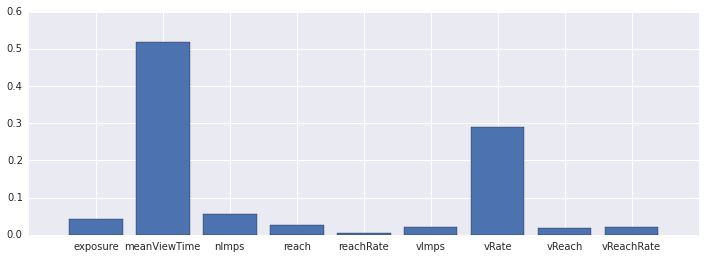

In [334]:
plt.rcParams["figure.figsize"] = [12.0, 4.0]
plt.bar(range(len(features)), model.feature_importances_, align='center')
_ = plt.xticks(range(len(features)), features)